In [1]:
import pytest
import numpy as np
import sys, os
import json
from pathlib import Path
import time

# sys.path.append(os.path.abspath(os.path.join('../..', 'examples')))
# from smart_em_script import get_microscope, get_get_rescan_map
import smartem
from smartem.smartem import SmartEM
from smartem.smartem_par import SmartEMPar
from smartem.online import microscope as microscope_client
from smartem.online import get_rescan_maps

from smartem.smartem_par import par_test

import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_38072/3773961829.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
repo_dir = Path("/Users/thomasathey/Documents/shavit-lab/smartem/SmartEM")
save_dir = "/Users/thomasathey/Desktop/temp"

In [3]:

# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16, "sleep": True}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em = SmartEM(microscope, get_rescan_map)

In [4]:

# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16, "sleep": True}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em_par = SmartEMPar(microscope, get_rescan_map)

In [5]:

with open(
    repo_dir / "examples/default_smartem_params.json",
    "r",
) as f:
    params = json.load(f)
    if "resolution" in params:
        params["resolution"] = tuple(params["resolution"])
    params["plot"] = False

# Don't acquire as many tiles as there will be sleeping involved
with open(
    repo_dir / "examples/default_imaging_params_short.json",
    "r",
) as f:
    params_imaging = json.load(f)
    params.update(params_imaging)

params["verbose"] = 0

smart_em.initialize()
smart_em_par.initialize()

In [6]:
data_total_times = []
data_task_times = []
data_method = []

smart_em.get_rescan_map.params["sleep_time"] = 0.5 # 2048x1768 pixels w/ 0.14 s/Mpx
smart_em_par.get_rescan_map.params["sleep_time"] = 0.5

params["sleep"] = True

for fast_dwt in tqdm([50e-9, 100e-9, 500e-9, 1000e-9]):
    for rep in tqdm(range(1), leave=False):
        params["fast_dwt"] = fast_dwt

        tic = time.time()
        smart_em.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_serial = time.time()
        smart_em_par.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_par = time.time()

        par_time = toc_par - toc_serial
        ser_time = toc_serial - tic
        print(f"{par_time} vs {ser_time}: {(ser_time-par_time)/ser_time*100}%")

        data_task_times.append(fast_dwt*5e6)
        data_total_times.append(par_time)
        data_method.append("Parallel")
        data_task_times.append(fast_dwt*5e6)
        data_total_times.append(ser_time)
        data_method.append("Serial")

data = {"Fast Imaging Time (s)": data_task_times, "Total Time (s)": data_total_times, "Method": data_method}
df = pd.DataFrame(data)


  0%|          | 0/4 [00:00<?, ?it/s]

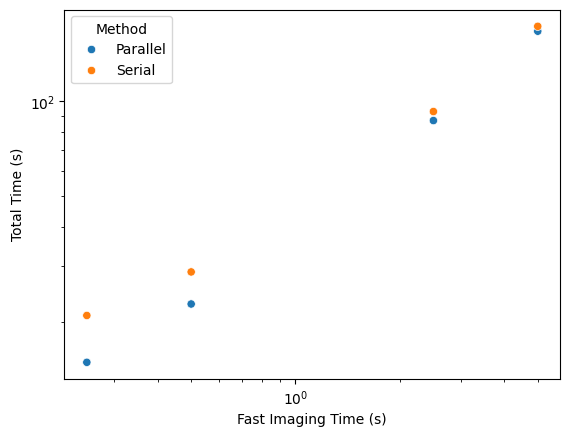

In [ ]:
sns.scatterplot(df, x="Fast Imaging Time (s)", y="Total Time (s)", hue="Method")
plt.xscale('log')
plt.yscale('log')